In [1]:
import tensorflow as tf

In [2]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [3]:
def get_lines(filepath):
    with open(filepath, 'r') as f:
        return f.readlines()

def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines=""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)-1
                abstract_samples.append(line_data)
        else:
            abstract_lines+=line
    return abstract_samples

def split_chars(text):
    return " ".join(list(text))

In [4]:
import os
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
get_lines(filenames[0])[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [6]:
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[2])

In [7]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


In [8]:
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()

train_sentences[:2]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .']

In [9]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [11]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  return {'accuracy' : model_accuracy,
          'precision' : model_precision,
          'recall' : model_recall,
          'f1' : model_f1}

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)
model_0_results = calculate_results(val_labels_encoded, model_0.predict(val_sentences))
model_0_results

{'accuracy': 67.64107976005333,
 'precision': 0.6805658878020778,
 'recall': 0.6764107976005332,
 'f1': 0.6349298999118057}

In [14]:
sent_length = [len(sentence.split()) for sentence in train_sentences]
tf.math.reduce_mean(sent_length).numpy()

26

In [15]:
int(np.percentile(sent_length, 95))

55

In [16]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=68000,
                                                    output_sequence_length=55)
text_vectorizer.adapt(train_sentences)

sample_sentence = 'hi there, how are you'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[4139,   63, 1093,   64,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [17]:
embedding = tf.keras.layers.Embedding(input_dim = 68000,
                                      output_dim=128,
                                      input_length=55,
                                      mask_zero=True)

embedding(text_vectorizer([sample_sentence]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.00864505,  0.03669078,  0.01636238, ...,  0.04884386,
         -0.03812522,  0.0306502 ],
        [ 0.01923699, -0.04637223,  0.03797653, ...,  0.03492644,
         -0.01390593,  0.03024346],
        [-0.02044984,  0.04830963, -0.03295499, ..., -0.04376416,
          0.00088583,  0.04443716],
        ...,
        [ 0.04938862, -0.04501325,  0.02389036, ..., -0.04464216,
         -0.01005546,  0.00308914],
        [ 0.04938862, -0.04501325,  0.02389036, ..., -0.04464216,
         -0.01005546,  0.00308914],
        [ 0.04938862, -0.04501325,  0.02389036, ..., -0.04464216,
         -0.01005546,  0.00308914]]], dtype=float32)>

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [19]:
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [20]:
inputs = tf.keras.layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_1 = model_1.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch = len(train_dataset),
                        validation_data = val_dataset,
                        validation_steps = int(0.2*len(val_dataset)))

Epoch 1/5
473/473 [==============================] - 23s 42ms/step - loss: 0.9010 - accuracy: 0.6382 - val_loss: 0.6953 - val_accuracy: 0.7384
Epoch 2/5
473/473 [==============================] - 4s 9ms/step - loss: 0.5363 - accuracy: 0.8082 - val_loss: 0.6524 - val_accuracy: 0.7667
Epoch 3/5
473/473 [==============================] - 4s 9ms/step - loss: 0.3752 - accuracy: 0.8727 - val_loss: 0.7127 - val_accuracy: 0.7593
Epoch 4/5
473/473 [==============================] - 5s 10ms/step - loss: 0.2551 - accuracy: 0.9175 - val_loss: 0.8379 - val_accuracy: 0.7464
Epoch 5/5
473/473 [==============================] - 4s 9ms/step - loss: 0.1744 - accuracy: 0.9473 - val_loss: 0.9952 - val_accuracy: 0.7343


In [21]:
model_pred_probs = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_pred_probs, axis = 1).numpy()
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

2814/2814 [==============================] - 8s 3ms/step


{'accuracy': 72.95989780048878,
 'precision': 0.7393745688497599,
 'recall': 0.7295989780048878,
 'f1': 0.7331882361699855}

In [22]:
#model_2 - USE

In [25]:
#character level

split_chars(train_sentences[0])

'i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .'

In [26]:
char_vocab_length = 28

import string
chars = string.ascii_lowercase+string.digits+string.punctuation
chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
char_vocab_length = len(chars) + 2
char_vocab_length

70

In [31]:
char_len = [len(sentence) for sentence in train_sentences]
np.percentile(char_len, 95)

290.0

In [33]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [34]:
train_chars[0]

'i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .'

In [35]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=70,
                                                    output_sequence_length=290)
char_vectorizer.adapt(train_chars)

In [37]:
char_vectorizer(['hello there, how are you'])

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()),
                                       output_dim=25,
                                       mask_zero=True)

In [41]:
char_embed(char_vectorizer(['hello there']))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-0.04167807, -0.01617049, -0.03756233, ..., -0.00423988,
         -0.04973081, -0.03577938],
        [-0.04167807, -0.01617049, -0.03756233, ..., -0.00423988,
         -0.04973081, -0.03577938],
        [ 0.00196416, -0.02038738, -0.00461473, ..., -0.01918158,
         -0.02678757, -0.04720476],
        ...,
        [ 0.00196416, -0.02038738, -0.00461473, ..., -0.01918158,
         -0.02678757, -0.04720476],
        [ 0.00196416, -0.02038738, -0.00461473, ..., -0.01918158,
         -0.02678757, -0.04720476],
        [ 0.00196416, -0.02038738, -0.00461473, ..., -0.01918158,
         -0.02678757, -0.04720476]]], dtype=float32)>

In [44]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)

In [45]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [48]:
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(32, kernel_size=3)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.models.Model(inputs, outputs)

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history3 = model_3.fit(train_char_dataset,
                       epochs=5,
                       validation_data = val_char_dataset,
                       validation_steps = int(0.2*len(val_char_dataset)),
                       steps_per_epoch=len(train_char_dataset))

Epoch 1/5
473/473 [==============================] - 11s 19ms/step - loss: 1.3739 - accuracy: 0.4207 - val_loss: 1.3231 - val_accuracy: 0.4535
Epoch 2/5
473/473 [==============================] - 7s 15ms/step - loss: 1.3072 - accuracy: 0.4587 - val_loss: 1.3157 - val_accuracy: 0.4549
Epoch 3/5
473/473 [==============================] - 7s 15ms/step - loss: 1.3033 - accuracy: 0.4601 - val_loss: 1.3143 - val_accuracy: 0.4555
Epoch 4/5
473/473 [==============================] - 7s 14ms/step - loss: 1.3018 - accuracy: 0.4606 - val_loss: 1.3136 - val_accuracy: 0.4560
Epoch 5/5
473/473 [==============================] - 7s 14ms/step - loss: 1.3008 - accuracy: 0.4606 - val_loss: 1.3130 - val_accuracy: 0.4558


In [50]:
model_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_pred_probs, axis = 1).numpy()
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

2814/2814 [==============================] - 8s 3ms/step


{'accuracy': 45.71095312152855,
 'precision': 0.4162379311175678,
 'recall': 0.45710953121528547,
 'f1': 0.4191500848879453}

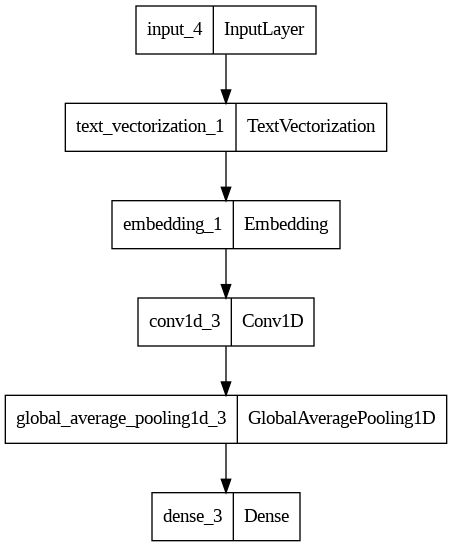

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [54]:
token_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
token_vectorizer = text_vectorizer(token_inputs)
token_embed = embedding(token_vectorizer)
token_avg = tf.keras.layers.GlobalAveragePooling1D()(token_embed)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_avg)
token_model = tf.keras.models.Model(token_inputs, token_outputs)

char_inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.models.Model(char_inputs, char_output)

token_char_concat = tf.keras.layers.Concatenate()([token_model.output, char_model.output])

combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(5, activation='softmax')(combined_dropout)

model_4 = tf.keras.models.Model(inputs = [token_model.input, char_model.input],
                                outputs = combined_dense)

model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_4.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['input_8[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 55, 128)              8704000   ['text_vectorization[3][

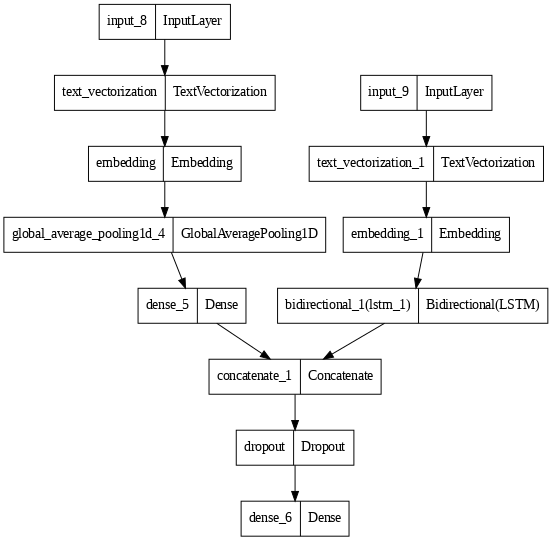

In [58]:
plot_model(model_4, dpi=70)

In [59]:
# creating new dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_one_hot = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_one_hot = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)


test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_one_hot = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_one_hot)).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
# if considering this as your final project, integrate the last two columns in the dataset and zip it with the target column
# you  might want to convert those numbers into its one-hot representation and then go ahead (not mandatory)